<a href="https://colab.research.google.com/github/rizkiar00/Self-Organizing-Maps/blob/master/SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; 
from google.colab import files
import numpy as np
import itertools 
import tensorflow as tf
import seaborn as sns
from scipy.spatial import distance
%matplotlib inline
!git clone https://github.com/rizkiar00/Self-Organizing-Maps

Cloning into 'Self-Organizing-Maps'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [2]:
my_data = np.genfromtxt('Self-Organizing-Maps/Tugas 2 ML Genap 2018-2019 Dataset Tanpa Label.csv', delimiter=',')
df = pd.DataFrame(data=my_data)
df

,0,1
0,9.802,10.132
1,10.350,9.768
2,10.098,9.988
3,9.730,9.910
4,9.754,10.430
5,9.836,9.902
6,10.238,9.866
7,9.530,9.862
8,10.154,9.820
9,9.336,10.456


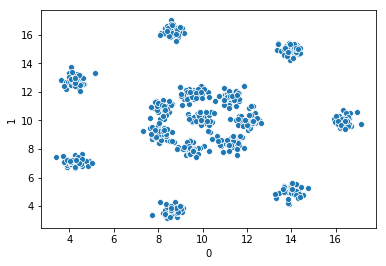

In [4]:
# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
ax = sns.scatterplot(x=df[0], y=df[1], data=df)

In [0]:
class SOM(object):
    def __init__(self, x, y, dimension, learning_rate, radius, iterasi):
        
        #Initialize properties
        self._x = x
        self._y = y
        self._learning_rate = float(learning_rate)
        self._radius = float(radius)
        self._iterasi = iterasi
        self._graph = tf.Graph()
 
        #Initialize graph
        with self._graph.as_default():
            
            #Initializing variables and placeholders
            self._weights = tf.Variable(tf.random_normal([x*y, dimension]))
            self._locations = self._generate_index_matrix(x, y)
            self._input = tf.placeholder("float", [dimension])
            self._iter_input = tf.placeholder("float")
 
            #Calculating BMU
            input_matix = tf.stack([self._input for i in range(x*y)])
            distances = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(self._weights, input_matix), 2), 1))
            bmu = tf.argmin(distances, 0)
            
            #Get BMU location
            mask = tf.pad(tf.reshape(bmu, [1]), np.array([[0, 1]]))
            size = tf.cast(tf.constant(np.array([1, 2])), dtype=tf.int64)
            bmu_location = tf.reshape(tf.slice(self._locations, mask, size), [2])
 
            #Calculate learning rate and radius
            decay_function = tf.subtract(1.0, tf.div(self._iter_input, self._iterasi))
            _current_learning_rate = tf.multiply(self._learning_rate, decay_function)
            _current_radius = tf.multiply(self._radius, decay_function)
 
            #Adapt learning rate to each neuron based on position
            bmu_matrix = tf.stack([bmu_location for i in range(x*y)])
            bmu_distance = tf.reduce_sum(tf.pow(tf.subtract(self._locations, bmu_matrix), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(bmu_distance, "float32"), tf.pow(_current_radius, 2))))
            learning_rate_matrix = tf.multiply(_current_learning_rate, neighbourhood_func)
 
            #Update all the weights
            multiplytiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_matrix, np.array([i]), np.array([1])), [dimension])
                                               for i in range(x*y)])
            delta = tf.multiply(
                multiplytiplier,
                tf.subtract(tf.stack([self._input for i in range(x*y)]), self._weights))                
                         
            new_weights = tf.add(self._weights, delta)
            self._training = tf.assign(self._weights, new_weights)                                       
 
            #Initilize session and run it
            self._sess = tf.Session()
            initialization = tf.global_variables_initializer()
            self._sess.run(initialization)
 
    def train(self, input_vects):
        for iter_no in range(self._iterasi):
            for input_vect in input_vects:
                self._sess.run(self._training,
                               feed_dict={self._input: input_vect,
                                          self._iter_input: iter_no})
 
        self._centroid_matrix = [[] for i in range(self._x)]
        self._weights_list = list(self._sess.run(self._weights))
        self._locations = list(self._sess.run(self._locations))
        for i, loc in enumerate(self._locations):
            self._centroid_matrix[loc[0]].append(self._weights_list[i])
    
    def _generate_index_matrix(self, x,y):
        return tf.constant(np.array(list(self._iterator(x, y))))
    
    def _iterator(self, x, y):
        for i in range(x):
            for j in range(y):
                yield np.array([i, j])

In [0]:
tf.print(tf.Variable(tf.random_normal([16, 2])))

<tf.Operation 'PrintV2' type=PrintV2>

In [6]:
som = SOM(4, 4, 2, 0.5, 1.0, 100)
som.train(my_data)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


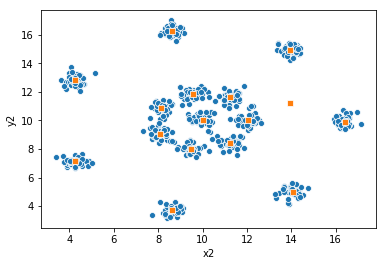

In [7]:
df1 = pd.DataFrame(my_data, columns=['x1', 'y1'])
df2 = pd.DataFrame(som._weights_list, columns=['x2', 'y2'])

fig, ax = plt.subplots()
sns.scatterplot(x=df1['x1'], y=df1['y1'], data=df1)
sns.scatterplot(x=df2['x2'], y=df2['y2'], data=df1,marker='s')


In [0]:
def categorize(a,b):
  idx = np.empty(len(a))
  for i in range(0,len(a)):
    best = 1000
    bestidx=0
    for j in range(0,len(b)):
      dist = distance.euclidean(a.loc[i], b.loc[j])
      if best > dist:
        best = dist
        bestidx = j
    idx[i] = bestidx
  kelas = pd.DataFrame(idx, columns=['class'])
  c = pd.merge(a, kelas, left_index=True, right_index=True)
  return c

In [14]:
c = pd.DataFrame()
c = categorize(df1,df2)
c

,x1,y1,class
0,9.802,10.132,10.0
1,10.350,9.768,10.0
2,10.098,9.988,10.0
3,9.730,9.910,10.0
4,9.754,10.430,10.0
5,9.836,9.902,10.0
6,10.238,9.866,10.0
7,9.530,9.862,10.0
8,10.154,9.820,10.0
9,9.336,10.456,10.0


In [15]:
c['class'].value_counts()

7.0     41
13.0    41
1.0     40
2.0     40
3.0     40
15.0    40
12.0    40
8.0     40
0.0     40
5.0     40
11.0    40
9.0     40
10.0    40
6.0     39
14.0    39
Name: class, dtype: int64

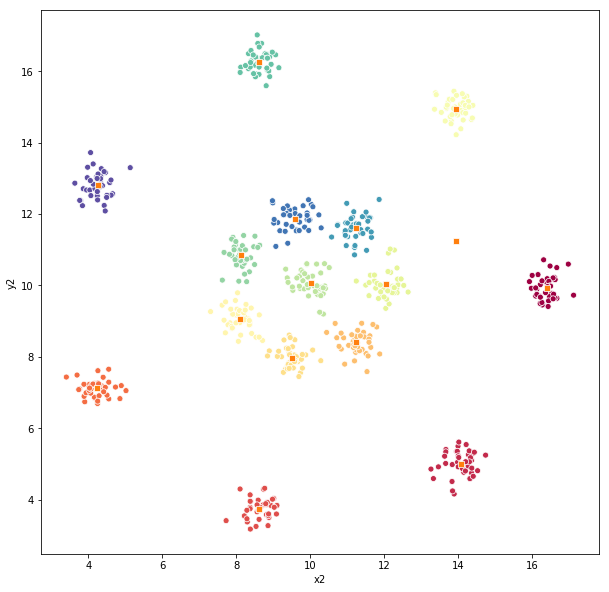

In [16]:
size = (10,10)
fig, ax = plt.subplots(figsize=size)
ax = sns.scatterplot(x="x1", y="y1",hue="class", data=c, palette="Spectral",legend=False)
ax = sns.scatterplot(x=df2['x2'], y=df2['y2'], data=df1,marker='s')